**Nome:** Iran Freitas Ribeiro

**Matrícula:** 2021241588

**Disciplina:** TEI - Estatística Aplicada

**Professor:** Celso José Munaro

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import OLS, ccf
plt.style.use("seaborn")

In [2]:
# x, y
Z = pd.read_csv("Data_epc10.csv", sep=";", header=None)
Z = Z.values
Ztreino_R = Z[:300]
ZCC_treino = Z[300:600]
ZCC_normal = Z[600:1200]
ZCC_falha = Z[1200:]

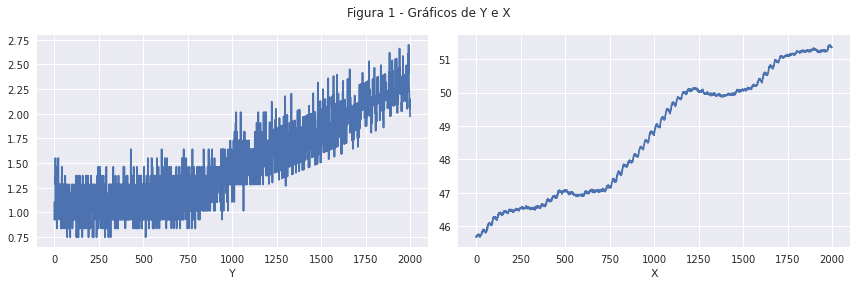

In [3]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(Z[:, 1])
ax[0].set_xlabel("Y")
ax[1].plot(Z[:, 0])
ax[1].set_xlabel("X")
plt.suptitle("Figura 1 - Gráficos de Y e X")
plt.tight_layout()

# Questão 1

In [4]:
X1 = Ztreino_R[:, 0]
Y1 = Ztreino_R[:, 1]

In [5]:
# treinamento do modelo
Xr = sm.add_constant(X1) # adiciona coluna com 1s
m1 = OLS(Y1, Xr)
res1 = m1.fit() # ajusta modelo nos dados
b0, b1 = res1.params # betas

In [6]:
# verificando o modelo com novos dados (ZCC_treino)
Xtreino = ZCC_treino[:, 0]
Ytreino = ZCC_treino[:, 1]
y_hat = [(b0 + b1*xi) for xi in Xtreino]

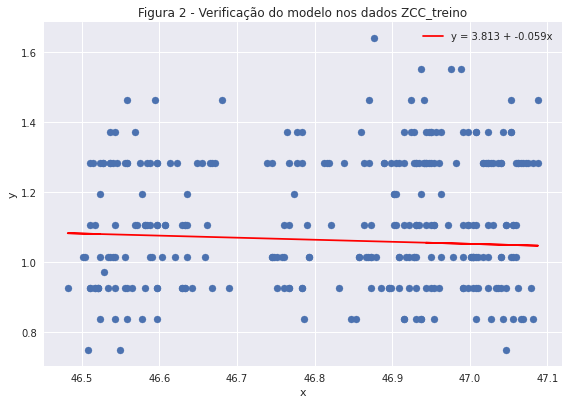

In [7]:
plt.scatter(Xtreino, Ytreino)
plt.plot(Xtreino, y_hat, c='red', label='y = {:.3f} + {:.3f}x'.format(b0, b1))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.title("Figura 2 - Verificação do modelo nos dados ZCC_treino");

In [8]:
residuos_zc = [yi - yi_hat for yi, yi_hat in zip(Ytreino,y_hat)]
crus_corr = ccf(residuos_zc, residuos_zc, adjusted=False)

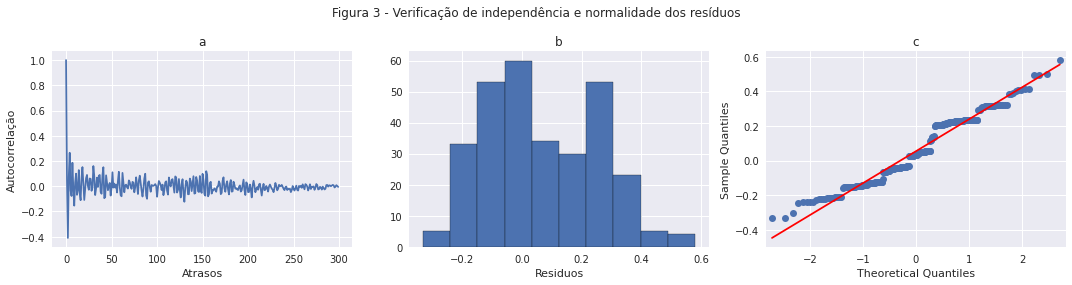

In [9]:
fig, ax = plt.subplots(figsize=(15,4), ncols=3)
ax[0].plot(crus_corr)
ax[1].hist(residuos_zc, edgecolor='black')
sm.qqplot(np.array(residuos_zc), line='s', ax=ax[2])
plt.suptitle("Figura 3 - Verificação de independência e normalidade dos resíduos")
ax[0].set_xlabel("Atrasos")
ax[0].set_ylabel("Autocorrelação")
ax[0].set_title("a")
ax[1].set_xlabel("Residuos")
ax[1].set_title("b")
ax[2].set_title("c")
plt.tight_layout();

# Questão 2

In [10]:
X2c = ZCC_treino[:, 0]
Y2c = ZCC_treino[:, 1]
b0, b1 = res1.params
# previsao de y usando X de ZCC_treino
Y_hat = [b0 + b1*xi for xi in X2c]


In [11]:
def controle(media, desvio, n, s=3):
    desvio_a = desvio/np.sqrt(n)
    ucl = media + s*desvio_a
    lcl = media - s*desvio_a
    return ucl, lcl

In [12]:
media_residuos, std_residuos = np.mean(residuos_zc), np.std(residuos_zc)

- Utilizar $n$ amostras ZCC_treino para obter os resíduos e calcular os limites do controle (ucl e lcl)
- Verificar FDR e FAR usando as bases ZCC_normal (true negative) e ZCC_falha (true positive)

In [13]:
X_normal = ZCC_normal[:, 0]
Y_normal = ZCC_normal[:, 1]

In [24]:
def get_amostras(X, Y, n):
    amostras_X = []
    amostras_Y = []
    i = 0
    while(i<len(X)):
        amostras_X.append(X[i:i+n])
        amostras_Y.append(Y[i:i+n])
        i = i+n
    return amostras_X, amostras_Y
    
def calc_media_residuos(amostrasX, amostrasY, b0, b1, n):
    medias_residuos = []
    for a_x, a_y in zip(amostrasX, amostrasY):
        if len(a_x)==n:
            y_hat_amostra = [b0 + b1*xi for xi in a_x]
            res_amostra = np.array(a_y) - np.array(y_hat_amostra)
            medias_residuos.append(res_amostra.mean())
    return medias_residuos

In [25]:
def testes_graficos_controle(X, Y, ns=[], mediac=0, stdc=1, params=[]):
    # fig, ax = plt.subplots(nrows=len(ns))
    b0, b1 = params
    # amostras_nointervalo = []
    ultrapassam = []
    nao_ultrapassam = []
    for i, n in enumerate(ns):
        amostras_X, amostras_Y = get_amostras(X, Y, n)
        ucl2, lcl2 = controle(mediac, stdc, n, s=6)
        medias_residuos = []
        # for a_x, a_y in zip(amostras_X, amostras_Y):
        #     if len(a_x)==n:
        #         y_hat_amostra = [b0 + b1*xi for xi in a_x]
        #         res_amostra = np.array(a_y) - np.array(y_hat_amostra)
        #         medias_residuos.append(res_amostra.mean())
        medias_residuos = calc_media_residuos(amostras_X, amostras_Y, b0, b1, n)
        medias_residuos = np.array(medias_residuos)
        dentro_intervalo = [1 for m in medias_residuos if (ucl2>m) and (m>lcl2)]    
        soma_dentro = sum(dentro_intervalo)
        nao_ultrapassam.append(soma_dentro)
        ultrapassam.append(len(medias_residuos) - soma_dentro)
    return ultrapassam, nao_ultrapassam

In [16]:
lista_n = np.arange(1,60)
ultrapassam_normal, n_ultrapassam_normal = testes_graficos_controle(X_normal, Y_normal, lista_n, mediac=media_residuos, stdc=std_residuos, params=[b0, b1])

In [17]:
X_falha = ZCC_falha[:, 0]
Y_falha = ZCC_falha[:, 1]

In [18]:
ultrapassam_falha, n_ultrapassam_falha = testes_graficos_controle(X_falha, Y_falha, lista_n, mediac=media_residuos, stdc=std_residuos, params=[b0, b1])

- TP = True Positive: amostras de [1201, 2000] que ultrapassam o limiar\*100/800
- FP = False Positive: amostras de [601,1200] que ultrapassam o limiar\*100/600
- FN = False Negative: amostras de [1201, 2000] que não ultrapassam o limiar\*100/800
- TN = True negative: amostras de [601,1200] que não ultrapassam o limiar\*100/600

In [19]:
def FDR(TP, FP):
    return TP/(TP+FP)
def FAR(FN, TN):
    return FN/(FN+TN)

In [20]:
fdrs = [FDR(tp, fp) for tp,fp in zip(ultrapassam_falha, ultrapassam_normal)]
fars = [FAR(fn,tn) for fn, tn in zip(n_ultrapassam_falha, n_ultrapassam_normal)]

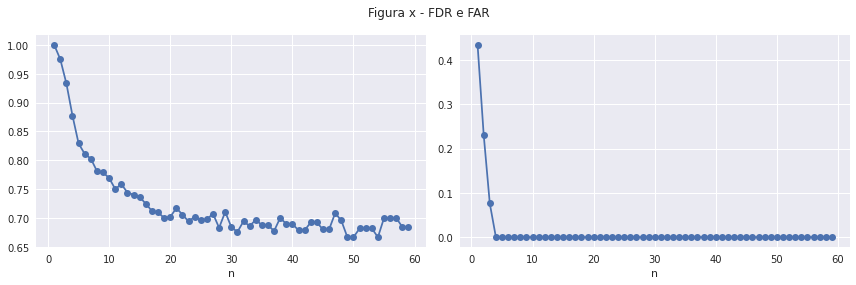

In [21]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(lista_n, fdrs, marker='o')
ax[1].plot(lista_n, fars, marker='o')
ax[0].set_xlabel("n")
ax[1].set_xlabel("n")
plt.suptitle("Figura 4 - FDR e FAR")
plt.tight_layout();

Utilizando n=7 na carta de controle

In [22]:
N = 5
ucl2, lcl2 = controle(media_residuos, std_residuos, N, s=6)
amostras_xnormal_c, amostras_ynormal_c = get_amostras(X_normal, Y_normal, N)
medias_normais_c = calc_media_residuos(amostras_xnormal_c, amostras_ynormal_c, b0, b1, N)

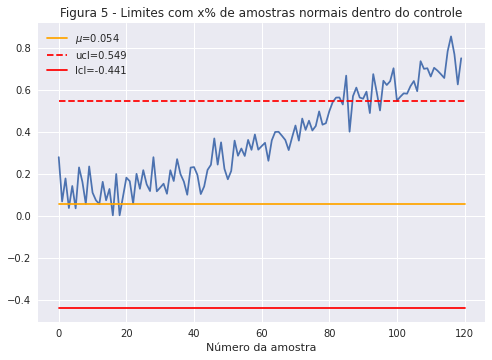

In [31]:
fig, ax = plt.subplots()
x = np.arange(len(medias_normais_c))
ax.plot(x, medias_normais_c)
ax.plot([0, len(x)], [media_residuos, media_residuos], c='orange', label=r'$\mu$={:.3f}'.format(media_residuos))
ax.plot([0, len(x)], [ucl2, ucl2], ls='--', c='red', label='ucl={:.3f}'.format(ucl2))
ax.plot([0, len(x)], [lcl2, lcl2], c='red', label='lcl={:.3f}'.format(lcl2))
plt.title("Figura 5 - Limites com x% de amostras normais dentro do controle")
ax.set_xlabel("Número da amostra")
plt.legend();

In [26]:
N = 5
amostras_xfalha_c, amostras_yfalha_c = get_amostras(X_falha, Y_falha, N)
medias_falha_c = calc_media_residuos(amostras_xfalha_c, amostras_yfalha_c, b0, b1, N)

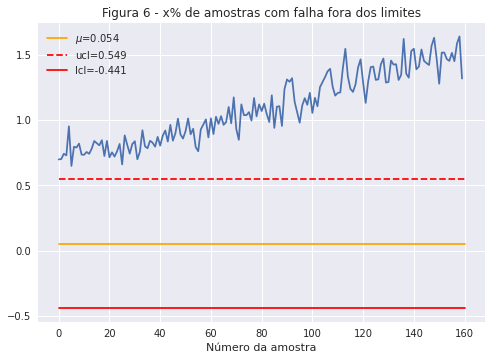

In [32]:
fig, ax = plt.subplots()
x = np.arange(len(medias_falha_c))
ax.plot(x, medias_falha_c)
ax.plot([0, len(x)], [media_residuos, media_residuos], c='orange', label=r'$\mu$={:.3f}'.format(media_residuos))
ax.plot([0, len(x)], [ucl2, ucl2], ls='--', c='red', label='ucl={:.3f}'.format(ucl2))
ax.plot([0, len(x)], [lcl2, lcl2], c='red', label='lcl={:.3f}'.format(lcl2))
plt.title("Figura 6 - x% de amostras com falha fora dos limites")
ax.set_xlabel("Número da amostra")
plt.legend();


# Questão 3

In [57]:
# separo as amostras de 10 em 10
amostras_xnormal_3, amostras_ynormal_3 = get_amostras(X_normal, Y_normal, 10)
medias_normais3 = calc_media_residuos(amostras_xnormal_3, amostras_ynormal_3, b0, b1, 10)
medias_normais3 = np.array(medias_normais3)
# medias falhas
amostras_xfalha_3, amostras_yfalha_3 = get_amostras(X_falha, Y_falha, 10)
medias_falha3 = calc_media_residuos(amostras_xfalha_3, amostras_yfalha_3, b0, b1, 10)
medias_falha3 = np.array(medias_falha3)

In [60]:
ms = [5, 10, 20]
medias_estimadas_normal = [np.mean(medias_normais3[:m]) for m in ms]
ranges_amostrais = [medias_normais3[:m].max() - medias_normais3[:m].min() for m in ms]
R_media_normal = np.mean(ranges_amostrais)

$\hat{\sigma} = \frac{\bar{R}}{d_2}$, pela Tabela $X$ no livro de referência, quando $n=10$, $d_2 = 3.078$, assim, podemos estimar o desvio padrão:

In [64]:
desvio_normal = R_media_normal/3.078
desvio_normal

0.046313316619497946

In [62]:
medias_estimadas_falha = [np.mean(medias_falha3[:m]) for m in ms]
ranges_amostrais = [medias_falha3[:m].max() - medias_normais3[:m].min() for m in ms]
R_media_falha = np.mean(ranges_amostrais)

In [65]:
desvio_falha = R_media_falha/3.078
desvio_falha

0.24861667589901873

In [69]:
lista_n = [10]
lista_ultrapassam_normal = []
lista_ultrapassam_falha = []
lista_nultrapassam_normal = []
lista_nultrapassam_falha = []
for m_n in medias_estimadas_normal:
    u_n, n_u_n = testes_graficos_controle(X_normal, Y_normal, lista_n, mediac=m_n, stdc=desvio_normal, params=[b0, b1])
    u_f, n_u_f = testes_graficos_controle(X_falha, Y_falha, lista_n, mediac=m_n, stdc=desvio_normal, params=[b0, b1])
    lista_ultrapassam_normal.append(u_n[0])
    lista_nultrapassam_normal.append(n_u_n[0])
    lista_ultrapassam_falha.append(u_f[0])
    lista_nultrapassam_falha.append(n_u_f[0])

In [70]:
fdrs = [FDR(tp, fp) for tp,fp in zip(lista_ultrapassam_falha, lista_ultrapassam_normal)]
fars = [FAR(fn,tn) for fn, tn in zip(lista_nultrapassam_falha, lista_nultrapassam_normal)]

In [49]:
len(fdrs)

3

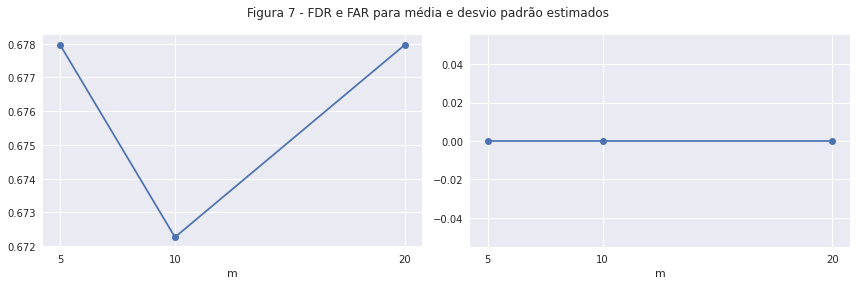

In [71]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(ms, fdrs, marker='o')
ax[1].plot(ms, fars, marker='o')
ax[0].set_xlabel("m")
ax[0].set_xticks([5, 10, 20])
ax[1].set_xlabel("m")
plt.suptitle("Figura 7 - FDR e FAR para média e desvio padrão estimados")
plt.xticks(ms)
plt.tight_layout();

In [72]:
ucl2, lcl2 = controle(medias_estimadas_normal[0], desvio_normal, 10, s=6)

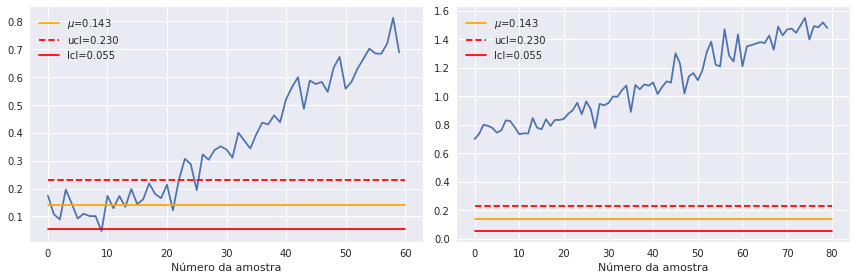

In [79]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
x = np.arange(len(medias_normais3))
mu = medias_estimadas_normal[0]
ax[0].plot(x, medias_normais3)
ax[0].plot([0, len(x)], [mu, mu], c='orange', label=r'$\mu$={:.3f}'.format(mu))
ax[0].plot([0, len(x)], [ucl2, ucl2], ls='--', c='red', label='ucl={:.3f}'.format(ucl2))
ax[0].plot([0, len(x)], [lcl2, lcl2], c='red', label='lcl={:.3f}'.format(lcl2))
ax[0].legend()
ax[0].set_xlabel("Número da amostra")
x = np.arange(len(medias_falha3))
ax[1].plot(x, medias_falha3)
ax[1].plot([0, len(x)], [mu, mu], c='orange', label=r'$\mu$={:.3f}'.format(mu))
ax[1].plot([0, len(x)], [ucl2, ucl2], ls='--', c='red', label='ucl={:.3f}'.format(ucl2))
ax[1].plot([0, len(x)], [lcl2, lcl2], c='red', label='lcl={:.3f}'.format(lcl2))
# plt.title("Figura 6 - x% de amostras com falha fora dos limites")
ax[1].set_xlabel("Número da amostra")
ax[1].legend()
#plt.title("Figura 5 - Limites com x% de amostras normais dentro do controle")
plt.tight_layout()
plt.legend();